In [21]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Reshape
import matplotlib.pyplot as plt

In [22]:
inputs = []
targets = []

In [23]:
for i in range(50):
    with open('dataset.json', 'r') as fp:
        data = json.load(fp)
        inputs = inputs + data['roi']
        targets = targets + data['peak']

In [24]:
inputs = np.array(inputs)
targets = np.array(targets)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(inputs, targets, test_size=0.1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [26]:
X_train.shape
input_shape=X_train[0].shape
input_shape

(20, 1)

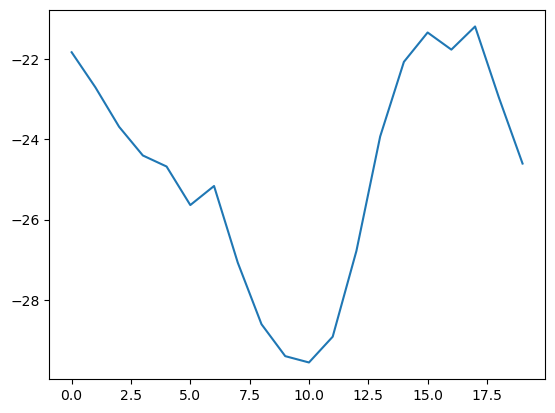

In [27]:
plt.plot(X_train[50])

In [28]:
model = Sequential()

model.add(Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=input_shape))

model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))

model.add(Flatten())

model.add(Dense(16, activation='relu'))

model.add(Dense(8, activation='relu'))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 18, 20)            80        
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 16)            976       
                                                                 
 conv1d_5 (Conv1D)           (None, 14, 8)             392       
                                                                 
 flatten_1 (Flatten)         (None, 112)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                1808      
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                

In [31]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100)

Epoch 1/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.5713 - binary_accuracy: 0.8459 - val_loss: 0.4789 - val_binary_accuracy: 0.9131
Epoch 2/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.4176 - binary_accuracy: 0.9265 - val_loss: 0.3688 - val_binary_accuracy: 0.9273
Epoch 3/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.3163 - binary_accuracy: 0.9382 - val_loss: 0.2820 - val_binary_accuracy: 0.9353
Epoch 4/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.2455 - binary_accuracy: 0.9441 - val_loss: 0.2302 - val_binary_accuracy: 0.9400
Epoch 5/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.1996 - binary_accuracy: 0.9477 - val_loss: 0.1900 - val_binary_accuracy: 0.9482
Epoch 6/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.1709 - binary_accuracy: 0.9505 - val_loss: 0.1679 - val_binary_accuracy: 0.9459
Epoch 7/100
1435/1435 [=======================

1435/1435 [==============================] - 2s 1ms/step - loss: 0.0372 - binary_accuracy: 0.9914 - val_loss: 0.0413 - val_binary_accuracy: 0.9914
Epoch 53/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.0354 - binary_accuracy: 0.9925 - val_loss: 0.0367 - val_binary_accuracy: 0.9914
Epoch 54/100
1435/1435 [==============================] - 2s 1ms/step - loss: 0.0344 - binary_accuracy: 0.9921 - val_loss: 0.0368 - val_binary_accuracy: 0.9935
Epoch 55/100
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0323 - binary_accuracy: 0.9925 - val_loss: 0.0332 - val_binary_accuracy: 0.9927
Epoch 56/100
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0308 - binary_accuracy: 0.9931 - val_loss: 0.0326 - val_binary_accuracy: 0.9900
Epoch 57/100
1435/1435 [==============================] - 2s 2ms/step - loss: 0.0302 - binary_accuracy: 0.9925 - val_loss: 0.0380 - val_binary_accuracy: 0.9886
Epoch 58/100
1435/1435 [=============================

In [32]:
prediction = model.predict(X_test)

160/160 [==============================] - 0s 733us/step


[1.]


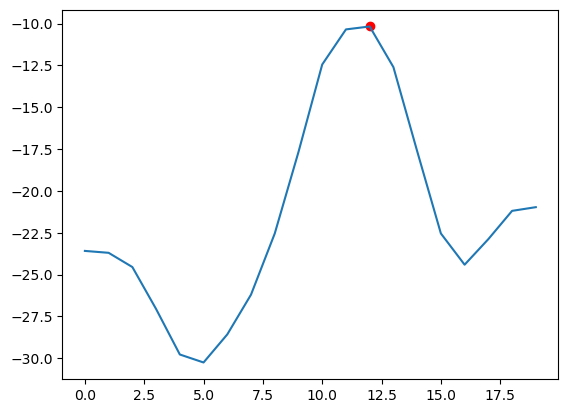

In [48]:
plt.plot(X_test[77])
plt.scatter(np.argmax(X_test[77]), max(X_test[77]), c='r')
print(prediction[77])

[0.00382746]


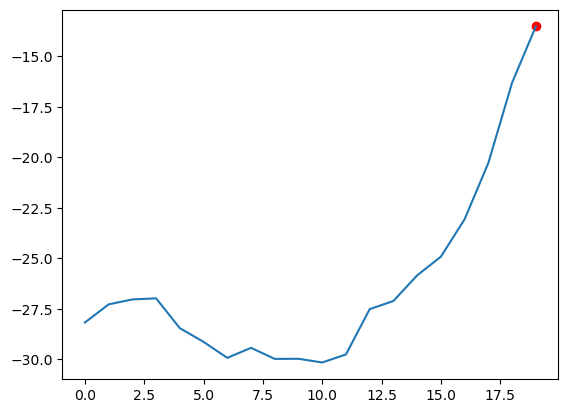

In [49]:
plt.plot(X_test[62])
plt.scatter(np.argmax(X_test[62]), max(X_test[62]), c='r')
print(prediction[62])

In [50]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
